# Iris Dataset

The goal is the classify the various iris observations into their correct labels. I am trying to use this  Notebook as a way to learn, but also teach about classification, KNN and KFold cross validation.  

## Getting the Data

For our Iris dataset we are using the data provided by UCI Machine Learning Repository. In order to make the data usable we read it into a Pandas dataframe.  We then split our data into the dependent variable y (the type of iris) and the independent variables X (the measurements).  We are calling .values  in order to make X and y NumPy ndarrays instead of leaving them as a dataframe in the case of X, and a series in the case of y. Ndarrays are significantly faster to work with than both Pandas objects as both a series and a dataframe require more overhead for things such as data type checking.  Note that y would have been a series because it is a one-dimensional object whereas X would have been a dataframe because it is two-dimensional. 

In [0]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/lanceeeaton/Iris_Dataset/master/iris_data.csv'
df = pd.read_csv(url, names = ['sepal_length','sepal_width','petal_length','petal_width','species'])

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

## Splitting our Data

Next, we need to split our data into 4 sets. We need a set of independent variables (X_train) and a set of dependent variables (y_train) to train our model on. We also need data to test our model on to see how accurate it is. This comes in the way of X_test and y_test. As you can see this is done with the use of sklearn's train_test_split function. The test_size parameter is a value between 0 and 1 that represents how much of the data should be allocated to the testing variables. We use .2 as 20% test size is fairly standard. There are many additional parameters you can set, one of which is random_state which makes it so each time the code is run the split is done in the same way this is done for reproducibility of results.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Making our Model

For our classification model we will be using the k-nearest neighbors model. If you look at the graph below you will see all our data points from our iris dataframe. Pick a random spot on the grid not already plotted, this will be your testing point.  If you have K = 1 in the K-nearest neighbors model, then the species of your testing point is just the species of the nearest plotted point. If you have K = 5 then the species of your point is whichever species is most occurring out of the 5 closest plotted points. This value K is called a hyperparameter and we need to find the right value for it as to not make our model overfit or underfit our dataset. To visualize this data, we are using seaborn and matplotlib, seaborn is built on matplotlib and adds some additional functionality.

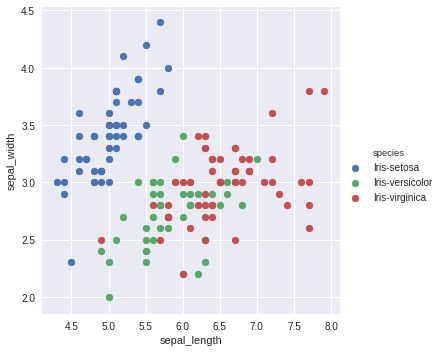

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

grid = sns.FacetGrid(df,hue='species',size = 5)
grid.map(plt.scatter,'sepal_length','sepal_width')
grid.add_legend()

## Finding K the wrong way
  

At first it would seem that the best way to find the right value of K would be to test a bunch of different values of K and pick the one that has the best testing accuracy. I know that this was what I originally thought I should do. The problem with this, is that your model is being tuned for predicting the test set which can lead to overfitting and an underestimating of error on out of sample data. The incorrect approach is done below. The metric we are using to tune the hyperparameter K is accuracy_score which is just how many labels were predicted correctly as a value between 0 and 1.  Although this approach as a whole is incorrect there is nothing wrong with the accuracy_score metric.

In the code below k_range is our range of K values we are testing, and accuracy_scores is a list to hold the accuracy measurement for each value of K. For each K we make a model and fit it to our training data. We then have our model make predictions on our independent testing matrix and put the accuracy of the prediction in our accuracy_scores list.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_range = list(range(1,51))
accuracy_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train,y_train)
  knn_pred = knn.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test,knn_pred))

## Graph of Results

In the graph below we can see that we have the highest testing accuracy when K is between 6 and 23. If we were going to use this method to tune our K value we would choose a value that lies within this range.  Note that the smaller value of K the more the model tends toward overfitting, so the higher the variance and lower the bias. The larger the value of K the more the model tends toward underfitting, so the lower the variance and higher the bias.

Text(0.5, 1.0, 'Accuracy for each Value of K in KNN')

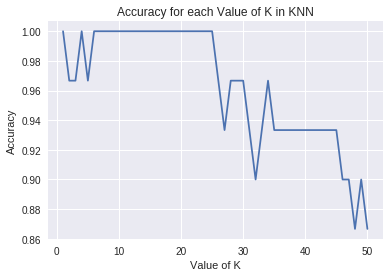

In [129]:
plt.plot(k_range,accuracy_scores)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Value of K in KNN')

#  k-fold cross validation

The main issue with how we arrived at K is that we are using our test set in evaluating hyperparameters. The second is that our model’s accuracy will vary greatly depending how our data is split in the train test split section of our code.  One way to get around this limitation is to use k-fold cross validation.  In k-fold cv we pick a number for k which is our number of folds (not to be confused with K in KNN), in our case we pick 10 as it often cited as a good amount of folds.  The data is then split into k bins, and we run k separate learning experiments, where each time you use k-1 bins for the training set and the remaining 1 is your validation set.  

For iteration of our loop we train the KNN model, split our training data into 10 bins, find the accuracy for 10 different separations of our training/validation data and take the average of these 10 learning experiments and append it to our scores list.  Everything to do with the k-fold process was done in the cross_val_score function. We now can decide what K value for KNN should yield the best results.

Note that this approach also allows us to use more data, which is very important when you don’t have a lot of data such as with the iris dataset. 




In [0]:
from sklearn.model_selection import cross_val_score

k_range = list(range(1,51))
scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train, y_train)
  cross_val_scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy')
  scores.append(cross_val_scores.mean())

## Graph of Results

The graph below shows our value of K in KNN and its associated cross validated accuracy. With this we can see that our accuracy rises fast but after around K = 13 it rapidly decreases. 

Text(0.5, 1.0, 'Cross Validated Accuracy for each Value of K')

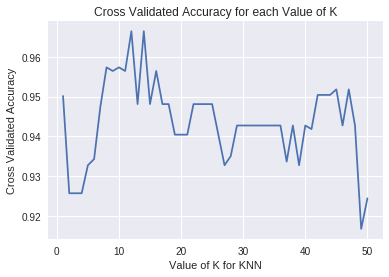

In [131]:
plt.plot(k_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross Validated Accuracy')
plt.title('Cross Validated Accuracy for each Value of K')

## Deciding on K value

In [132]:
best_ks = np.where(scores == max(scores))[0]
print(best_ks)

[11 13]


We can see that our best K value is a tie between 11 and 13. One of these values will be our final K value. I chose 13 as it is the higher value, so it will have lower variance, and tend more towards underfitting. In the code below, we get to see how accurate our model is on the testing data we set aside at the very beginning.

In [133]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
accuracy_score(y_test,knn_pred)

1.0

We achieve 100% accuracy, this seems a little worrisom as nearly no models are 100% accurate. What I have done below is preformed 200 different train test splits of the data and then predicted the the test set with our K value being 13. Ideally we would be able to get new iris data to test our model on but this should give us a decent idea of our overal model accuracy. 

In [0]:
final_scores = []
test_loops = list(range(1,201))

for i in test_loops:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  knn = KNeighborsClassifier(n_neighbors = 13)
  knn.fit(X_train, y_train)
  knn_pred = knn.predict(X_test)
  final_scores.append(accuracy_score(y_test,knn_pred))

## Graph of our Results

Below is a graph of our model’s accuracy for each iteration of the loop. The red line is the average of all these accuracies. The graph will look different each time the code is run, but the average should always be around 97%. So, we can say with some certainty that our model is about 97% accurate.

Text(0, 0.5, 'Accuracy')

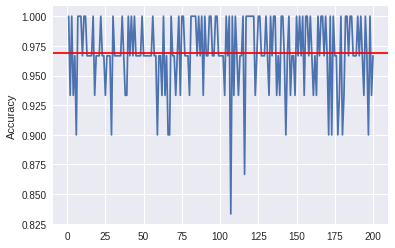

In [142]:
average_accuracy = np.array(final_scores).mean()
plt.plot(test_loops,final_scores)
plt.axhline(y = average_accuracy,color = 'red')
plt.ylabel('Accuracy')

### Acknowledgements

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.